In [13]:
import socket
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from scipy import signal
import pandas as pd
import struct

In [14]:
UDP_IP = "192.168.3.40"
UDP_PORT = 4096

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind((UDP_IP,UDP_PORT))

In [15]:
# def parse_packet():
#   data = sock.recv(9000)
#   if len(data) <  8000:
#     print("invalid packet recieved")
#   print(len(data))
#   spec_data = np.frombuffer(data, dtype = '<i')
#   return spec_data # int32 data type

In [26]:
def parse_packet():
  data = sock.recv(8208 * 1)
  if len(data) <  8000:
    print("invalid packet recieved")
  print(len(data))
# to change byte assignments in data - we need to make it a bytarray because bytes type is not changable
  datarray = bytearray(data)
#  datarray[38:40] = datarray[54:56]
# the above step unrolls the c0ffee data stream
  for i in range(499):
        datarray[214+i*16:216+i*16]=datarray[230+i*16:232+i*16]
#  datarray[54:56] = b'\x00\x00'
# the above step redefines the next bytes after c0ffee as zeros

# after looking at the data - it appears that it is in little endian format which is good
# the LSB is in address 238 or 239 (not sure about indexing)

  print(datarray[200:250])
# now allow a shift of the bytes
  byte_off = 6
  for i in range(byte_off):
    datarray.append(0)
  spec_data = np.frombuffer(datarray, dtype = '<i', offset = byte_off)
# offset allows a shift in the bytes
  return spec_data # int32 data type


8208
bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb7\x98\xff\xff\xea\xeb\x02\x00\xcc\xf9\xfd\xff\xb0\xbc\xfd\xff\xa5\x03\x03\x00\x90\x80\xff\xff\xe4c\x01\x00\xe5B\xfd\xff\x00\xb9\x02\x00')
1026
[   0.          -25.82128906 -129.55078125  192.91113281   88.97265625]
[   0.          186.97851562 -144.828125    -31.859375   -175.27636719]


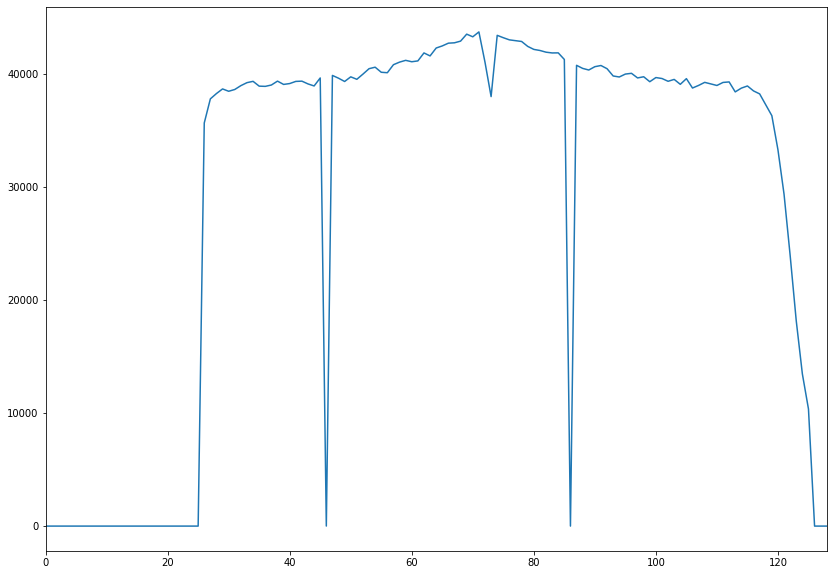

In [27]:
d = parse_packet()
data1 = np.array(d).astype("float")/2**10
I=data1[::2]
Q=data1[1::2]
print(len(Q))
print(I[25:30])
print(Q[25:30])
plt.figure(figsize=(14,10))
plt.xlim(0,128)
plt.plot(I**2 + Q**2)

In [ ]:
data = sock.recv(8208 * 1)
ord(data[248])  

In [ ]:
def parse_packet():
  data = sock.recv(9000)
  if len(data) <  8000:
    print("invalid packet recieved")
  spec_data = np.fromstring(data, dtype = '<i')
  return spec_data # int32 data type



def get_timestamp(timestamp_data):
    """
      Casting packet timing information 
    """
    td=int(timestamp_data,16)
#     print(timestamp_data)
#     print(td)
    free_count   = (td & int("FFFFFFFF0000000000000000000000",16))>>88
    packet_count = (td & int("00000000FFFFFFFF00000000000000",16))>>56
    pps_count    = (td & int("0000000000000000FFFFFFFF000000",16))>>24
    GPIO         = (td & int("000000000000000000000000FFFF00",16))>>8 
    PMOD         = (td & int("0000000000000000000000000000FF",16))    

    return (free_count, packet_count, pps_count, GPIO, PMOD)

def check_pps_count():
  pcount=[]
  for i in range(25):
    sleep(0.5)
    t_info, _ = parse_packet()
    (_, _, pps_count, _, _) = get_timestamp(t_info)
    #(_, packet_count, _, _, _) = get_timestamp(t_info)
    pcount.append(pps_count)
  return np.array(pcount)

def check_packet_count():
  pcount=[]
  for i in range(25):
    sleep(0.5)
    t_info, _ = parse_packet()
    #(_, _, pps_count, _, _) = get_timestamp(t_info)
    (_, packet_count, _, _, _) = get_timestamp(t_info)
    pcount.append(packet_count)
  return np.array(pcount)


def print_time():
  t_info, _ = parse_packet()
  (free_count, packet_count, pps_count, GPIO, PMOD) = get_timestamp(t_info)
  #print("""
  #free_count    |  0x{free_count  :x}
  #packet_count  |  0x{packet_count:x}
  #pps_count     |  0x{pps_count   :x}
  #GPIO          |  0x{GPIO        :x}
  #PMOD          |  {PMOD        :b}b
  #""")

  return

def print_max_value():
  for i in range(100000):
    data = parse_packet()
    I, Q = data[0::2], data[1::2]
    maxI_idx = np.where(abs(I)==max(abs(I)))[0][0]
    maxQ_idx = np.where(abs(Q)==max(abs(Q)))[0][0]
    print(str(maxI_idx)+" "+str(I[maxI_idx])+" "+str(maxQ_idx)+" "+str(Q[maxQ_idx]))
  return 0

def print_packet_data(Ichan, Qchan):
  for i in range(100000):
    data_2 = parse_packet()
    print(str(data_2[Ichan])+" " +str(data_2[Qchan]))
  return 0

def otra_print_packet_data(pkt_index):
  chan=2*pkt_index
  for i in range(100000):
    data_2 = parse_packet()
    print("I: {} Q: {}".format(data_2[chan+1],data_2[chan]))
  return 0

def capture_packets(N_packets):
  packets = np.zeros(shape=(2052,N_packets))
  #packets = np.zeros(shape=(2051,N_packets))
  for i in range(N_packets):
    data_2 = parse_packet()
    packets[:,i] = data_2 
  return packets

def phase_noise(I_idx, Q_idx, N_packets = 1024, nperseg=1024):
  data = capture_packets(N_packets)
  #I, Q = data[packet_index], np.roll(data[packet_index+1],1)
  f, S = signal.welch(np.arctan2(data[Q_idx],data[I_idx]),fs=512e6/2**20,nperseg=nperseg)
  plt.semilogx(f,10*np.log10(S))
  plt.ylabel("dBc/Hz", fontsize=16); plt.xlabel("freq.", fontsize=16)
  #if save:
  #  np.savez("~/Pictures/phasenosie",f,S)
  plt.show()
  return 0

def phase_noise2(packet_index, N_packets = 1024, nperseg=1024, alpha=1.0, save=False):
  data = capture_packets(N_packets)
  I, Q = data[packet_index], np.roll(data[packet_index+1],1)
  f, S = signal.welch(np.arctan2(Q,I),fs=512e6/2**20,nperseg=nperseg)
  plt.semilogx(f,10*np.log10(S),color="blue",alpha=alpha)
  plt.ylabel("dBc/Hz", fontsize=16); plt.xlabel("freq.", fontsize=16)
  plt.show()
  if save:
    np.savez("1k_phasenosie",f,S)
  return 0

def phase_noise_all(nstart, nstop, nstep=1, N_packets = 1024, nperseg=1024,color="blue", alpha=1.0):
  data = capture_packets(N_packets)
  for a in range(nstart,nstop,nstep):
    I, Q = data[2*a], np.roll(data[2*a+1],1)
    f, S = signal.welch(np.arctan2(Q,I),fs=512e6/2**20,nperseg=nperseg)
    plt.semilogx(f,10*np.log10(S),color=color,alpha=alpha)
  plt.ylabel("dBc/Hz", fontsize=16); plt.xlabel("freq.", fontsize=16)
  plt.show()
  return 

def phase_noise_iq(packet_index, N_packets = 1024, nperseg=1024):
  data = capture_packets(N_packets)
  I, Q = data[packet_index], np.roll(data[packet_index+1],1)
  f, Si = signal.welch( I, fs=512e6/2**20, nperseg=nperseg)
  f, Sq = signal.welch( Q, fs=512e6/2**20, nperseg=nperseg)
  phi = ( Si + Sq)/(np.mean(I)**2 + np.mean(Q)**2)/2.
  plt.semilogx(f,10*np.log10(phi),label='Phil Noise')
  #plt.semilogx(f,10*np.log10(Si),label='I')
  #plt.semilogx(f,10*np.log10(Sq),label='Q')
  plt.ylabel("dBc/Hz", fontsize=16); plt.xlabel("freq.", fontsize=16)
  plt.legend()
  plt.show()
  return 0

import os
def live_plot(beep=False,ymax=3e9):
  plt.figure()
  while 1:
    data = parse_packet()
    I, Q = data[0::2][0:1024], data[1::2][0:1024]
    Ia, Qa = np.array(I).astype(float), np.array(Q).astype(float)
    plt.clf()
    IQmag=np.sqrt(Ia**2 + Qa**2)
    if (beep and np.max(IQmag)>0.5e9):
      os.system("beep -r 2")
      print("Max Found!")
    plt.plot(10.*np.log10(IQmag))
    plt.ylim(1, 99)#ymax)
    plt.xlim(0,1024)
    plt.pause(0.01)
  plt.show()
  return 0

def magick():
  pkts=capture_packets(8192)
  I=pkts[129,:]
  Q=pkts[130,:]
  
  plt.subplot(211)
  plt.hist(I,bins=1024)
  plt.subplot(212)
  plt.hist(Q,bins=1024)
  plt.show()

In [ ]:
data = capture_packets(1024)
np.save("packet-data-may272022_test1",data)

In [ ]:
data.shape # (channel, packet #)

In [ ]:
data = capture_packets(1024)
plt.plot(abs(data[:,0]).astype("int32"))

plt.figure()
x=np.argmax(abs(data[:,0]))
c=38
plt.plot((data[c:100,0]),"+-")
plt.figure()
plt.plot(data[21,100:200]-np.mean(data[21,100:200]),label="I-<I>")
plt.plot(data[22,100:200]-np.mean(data[22,100:200]),label="Q-<Q>")
plt.legend(); plt.show()
plt.plot(abs(data[21,100:]-np.mean(data[21,100:])),label="I-<I>")

print(str(int(np.mean(data[41,100:200]))))
print(str(int(np.mean(data[42,100:200]))))

In [ ]:
max(abs(data[41,100:]-np.mean(data[41,100:])))*1e-6

In [ ]:
min(abs(data[41,100:]-np.mean(data[41,100:])))*1e-6

In [ ]:
int(np.mean(data[41,100:]))

In [ ]:
d41I=data[45,100:]
d41Q=data[46,100:]
d41I=d41I[d41I<np.max(d41I)]
d41Q=d41Q[d41Q<np.max(d41Q)]
f, Si1 = signal.welch( d41I, fs=512e6/2**20, nperseg=256)
f, Sq1 = signal.welch( d41Q, fs=512e6/2**20, nperseg=256)
#phi1 = ( Si1 + Sq1)/(np.mean(d41I)**2 + np.mean(d41Q)**2)/2.
#phi2 = ( Si1 + Sq1)/(np.mean(d41I)**2 + np.mean(d41Q)**2)/2.
#phi10a = ( Si1 + Sq1)/(np.mean(d41I)**2 + np.mean(d41Q)**2)/2.
#phi100 = ( Si1 + Sq1)/(np.mean(d41I)**2 + np.mean(d41Q)**2)/2.
#phi500 = ( Si1 + Sq1)/(np.mean(d41I)**2 + np.mean(d41Q)**2)/2.
phi1000 = ( Si1 + Sq1)/(np.mean(d41I)**2 + np.mean(d41Q)**2)/2.
plt.semilogx(f,10*np.log10(phi1000),label='Phil Noise')
plt.show()

In [ ]:
def saveToDirfile(subfolder, start_chan, end_chan, time_interval):
    d = gd.dirfile(filename,gd.CREAT|gd.RDWR|gd.UNENCODED)
    for chan in range(chan_start,chan_stop+1):
        d.add_spec('I_' + str(chan) + ' RAW FLOAT64 1')
        d.add_spec('Q_' + str(chan) + ' RAW FLOAT64 1')

In [ ]:
plt.figure(figsize=(12,7))
plt.semilogx(f,10*np.log10(phi1),"+-",label='1-tone')
plt.semilogx(f,10*np.log10(phi2),"+-",label='2-tone')
plt.semilogx(f,10*np.log10(phi10),"+-",label='10-tone')
plt.semilogx(f,10*np.log10(phi100),"+-",label='100-tone')
plt.semilogx(f,10*np.log10(phi500)-4,"+-",label='500-tone')
plt.semilogx(f,10*np.log10(phi1000)-4,"+-",label='1000-tone')
plt.legend()
plt.ylabel("Phase Noise [dBc/Hz]",fontsize=16); plt.xlabel("freq.",fontsize=14)
plt.ylim(-120,-80)
plt.savefig("multitone-fake-modified-Phasenoise-plots.png")
plt.grid()
plt.show()

# Timing Characterization

In [ ]:
# Repeatedly run this code block to see the status of the pmods. Note: this should be instant, if this block hangs, the network config may
# have erroneously changed or something mysterious has happened. 
for i in range(24):
    
    print(bin(get_timestamp(data[0])[4]))

In [ ]:
data = parse_packet_wtime()
print(bin(get_timestamp(data[0])[4]))

In [ ]:
data = parse_packet()
I, Q = data[0::2][0:1024], data[1::2][0:1024]
print("Total = {} bytes in length".format(len(I)*4 + len(Q)*4))

In [ ]:
ts, spec = parse_packet_wtime()
pps = get_timestamp(ts)[2]
pcount = get_timestamp(ts)[1]
print("pps:   {} \t\t-> {}".format(pps, bin(pps)))
print("pcount:{} \t-> {}".format(pcount, bin(pcount)))

In [ ]:
pktTable = []
for i in range(14):
    pktTable.append(parse_packet_wtime())

In [ ]:
def getCounterData(N):
    for i in range(N):
        ts, spec = parse_packet_wtime()
        pps = get_timestamp(ts)[2]
        pcount = get_timestamp(ts)[1]
        print("pps:   {} \t\t-> {}".format(pps, bin(pps)))
        print("scount:{} \t-> {}".format(pcount, bin(pcount)))
        
# 0b10111011010101
# 0b10111011010111

In [ ]:
getCounterData(14)

In [ ]:
def parse_packet_into_bytes():
  #for i in range(50):
   # data = sock.recv(8208)
  data = sock.recv(8208)
  if len(data) <  8000:
    print("invalid packet recieved")
#   print(len(data))
  #spec_data = np.frombuffer(data, dtype = '<i')
  return data # int32 data type

In [ ]:
data = parse_packet_into_bytes()
# [-1] pmod - byte
# [-3:-1] gpio - 2 bytes
# [-7:-3] pcount (pps count) 4 bytes
# [-11:-7] scount (packet count) 4 bytes
# [-15:-11] fcount (fine count) 4 bytes

In [ ]:
for x in data[-4:-2]:
    print("{}->{}".format(hex(x), bin(x)))

In [ ]:
for _ in range(15):
    data = parse_packet_into_bytes()
    print(data[-16:].hex())

In [ ]:
from struct import unpack
print( unpack(">I",data[-11:-7]))

In [ ]:
val = []
sock.recv(9000)
for i in range(48):
    parse_packet_into_bytes()
for i in range(500):
    data = parse_packet_into_bytes()
#     print( unpack(">I",data[-15:-11]))
    val.append(unpack(">I",data[-11:-7])[0])
                  
#     print(type(data[-1]))
#     print(data[-1])
    #val.append(data[-1])

In [ ]:
import matplotlib.pyplot as plt
#Changed in version 0.25.0: If data is a list of dicts, column order follows insertion-order.

In [ ]:
plt.plot(val[0:])
plt.figure()
plt.plot(np.diff(val)[0:])

In [ ]:
for ind,dat in enumerate(val[0:]):
    print(f"{bin(dat):32} {hex(dat):16} {val[ind]-val[ind-1]}")


In [ ]:
sock.recv?

In [ ]:
def samplePPS():
    from time import sleep
    from struct import unpack
    # Extract One Packet and seperate it all into seperate variables

    while(1):
        data = parse_packet_into_bytes()
        pmod = data[-1]
        gpio = data[-3:-1] # gpio - 2 bytes
        pps = unpack('>I', data[-7:-3])[0] # pcount (pps count) 4 bytes
        scount = unpack('>I', data[-11:-7])[0]# scount (packet count) 4 bytes
        fcount =  unpack('>I',data[-15:-11])[0]# fcount (fine count) 4 bytes
        spec_data = np.frombuffer(data, dtype = '<i')
        Iraw, Qraw = spec_data[0::2][0:1024], spec_data[1::2][0:1024]

        I, Q = np.array(Iraw).astype(float), np.array(Qraw).astype(float)
        d = {'I': I, 'Q' : Q, 'PMOD':pmod, 'PKTCOUNT' : scount, 'FREECOUNT':fcount, "PPS" : pps}
        df = pd.DataFrame(data=d)
        print(df['PPS'][0])

        sleep(1)

In [ ]:
samplePPS

In [ ]:
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]

## Data Handling Segment


In [ ]:
# Extract One Packet and seperate it all into seperate variables

data = parse_packet_into_bytes()
pmod = data[-1]
gpio = data[-3:-1] # gpio - 2 bytes
pps = unpack('>I', data[-7:-3])[0] # pcount (pps count) 4 bytes
scount = unpack('>I', data[-11:-7])[0]# scount (packet count) 4 bytes
fcount =  unpack('>I',data[-15:-11])[0]# fcount (fine count) 4 bytes
spec_data = np.frombuffer(data, dtype = '<I')
Iraw, Qraw = spec_data[0::2][0:1024], spec_data[1::2][0:1024]

hello = "hello world"

I, Q = np.array(Iraw).astype(float), np.array(Qraw).astype(float)
d = {'I': I, 'Q' : Q, 'PMOD':pmod, 'PKTCOUNT' : scount, 'FREECOUNT':fcount, "PPS" : pps}
IQd =  {'I': I, 'Q' : Q}
df = pd.DataFrame(data=d)
IQdf = pd.DataFrame(data=IQd)
df


In [ ]:
def getNewPacketData():
    data = parse_packet_into_bytes()
    pmod = data[-1]
    gpio = data[-3:-1] # gpio - 2 bytes
    pps = unpack('>I', data[-7:-3])[0] # pcount (pps count) 4 bytes
    scount = unpack('>I', data[-11:-7])[0]# scount (packet count) 4 bytes
    fcount =  unpack('>I',data[-15:-11])[0]# fcount (fine count) 4 bytes
    spec_data = np.frombuffer(data, dtype = '<I')
    Iraw, Qraw = spec_data[0::2][0:1024], spec_data[1::2][0:1024]

    I, Q = np.array(Iraw).astype(float), np.array(Qraw).astype(float)
    d = {'I': I, 'Q' : Q, 'PMOD':pmod, 'PKTCOUNT' : scount, 'FREECOUNT':fcount, "PPS" : pps}
    #timestamp = {'PMOD':pmod, 'PKTCOUNT' : scount, 'FREECOUNT':fcount, "PPS" : pps}
    #timestampDF = pd.DataFrame(data=timestamp).to_numpy()
    IQd =  {'I': I, 'Q' : Q}
    df = pd.DataFrame(data=d).to_numpy()
    IQdf = pd.DataFrame(data=IQd).to_numpy()
    return df

In [ ]:
helpme = getNewPacketData()
#print(katdata[0])
iq = helpme[:, 0:2]
ts = helpme[:, 2:6]
#print(helpme)
#print("IQ: ", iq)
#print("Timestamp: ", ts)
#print(iq.shape)
#concat = np.concatenate((ts[0:0],iq[0,:]), axis=0)
print(ts[0])
one_ts = ts[0]
#print(one_ts)
#print(one_ts.shape) 
int("".join(map(str, one_ts)))

list_str = (one_ts)
list = [list_str, iq]
print(list_str)
#print(list)
#np.savetxt('ts.txt', list, fmt='%d', header='')
#ts_and_i = np.insert(arr=iq, obj = slice, values=one_ts, axis=0)

In [ ]:
np.savetxt('makesmesad.txt', IQdf, fmt='%d', header=text_header)

In [ ]:
#helpme = getNewPacketData()
#np.savetxt('makesmesad.txt', IQdf, fmt='%d', header=text_header)
for x in range(2):
    #katdata = getNewPacketData()
    helpme = getNewPacketData()
    iq = helpme[:, 0:2]
    print(x)
    print(iq)
    if x == 0:
        np.savetxt('makesmesad.txt', iq, fmt='%d', header=text_header)
        print("first IQ data at x =0: ", iq[0])
    if x >= 1:
        for i in range(2):
            dataset = np.genfromtxt('makesmesad.txt')
            d = iq[:,i]
            d = np.reshape(d, (dataset.shape[0],1))   # adjust dimension of the new array
            result = np.append(dataset, d, 1)         # append as last column
            print(result.shape)
            list = np.array([[44,55,10]])
            print(list.shape)
            #result2 = np.append(result, np.array([[44,55,10]]), axis=0)
            np.savetxt('makesmesad.txt', result, delimiter=" ", header='i and q data', fmt="%s")

In [ ]:
for i in range(3):
    katdata = getNewPacketData()
    print(katdata)

In [ ]:
NUMPKTS = 10
for i in range(NUMPKTS):
    data = parse_packet_into_bytes()
    pmod = data[-1]
    gpio = data[-3:-1] # gpio - 2 bytes
    pps = unpack('>I', data[-7:-3])[0] # pcount (pps count) 4 bytes
    scount = unpack('>I', data[-11:-7])[0]# scount (packet count) 4 bytes
    fcount =  unpack('>I',data[-15:-11])[0]# fcount (fine count) 4 bytes
    spec_data = np.frombuffer(data, dtype = '<I')
    Iraw, Qraw = spec_data[0::2][0:1024], spec_data[1::2][0:1024]

    I, Q = np.array(Iraw).astype(float), np.array(Qraw).astype(float)
    d = {'I': I, 'Q' : Q, 'PMOD':pmod, 'PKTCOUNT' : scount, 'FREECOUNT':fcount, "PPS" : pps}
    IQd =  {'I': I, 'Q' : Q}
    df = pd.DataFrame(data=d)
    IQdf = pd.DataFrame(data=IQd)
    df
    print(i)

In [ ]:
header4 = df['PPS'][0]
header1 = df['PMOD'][0]
header2 = df['PKTCOUNT'][0]
header3 = df['FREECOUNT'][0]
headerD = to_str(header4)
headerA =  to_str(header1)
headerB =  to_str(header2)
headerC =  to_str(header3)

text_header=headerA + headerB + headerC + headerD
print(text_header)

file_name = 'makesmesad.txt'

np.savetxt(file_name, IQdf.values, fmt='%d', header=text_header)
df.to_csv(r'pandas.csv', header=text_header, index=None, sep=' ', mode='a')

In [ ]:
np.savetxt('makesmesad.txt', IQdf, fmt='%d', header=text_header)
np.savetxt('test2.txt', IQdf, fmt='%d', header=text_header)

In [ ]:
for i in range(2):
    dataset = np.genfromtxt('makesmesad.txt')
    d = np.genfromtxt('test2.txt')
    print(type(d))
    dd = 1*dataset[:,i]
    #d = 1*dataset[:,i]
    print(d)
    dd = np.reshape(dd, (dataset.shape[0],1))   # adjust dimension of the new array
    result = np.append(dataset, dd, 1)         # append as last column
    np.savetxt('makesmesad.txt', result, delimiter=" ", header='i and q data', fmt="%s")